In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from fredapi import Fred

fred = Fred(api_key= '2d60db8717ba3d033f961ac04cf4855e')
ten_year_treasury_rate = fred.get_series('GS10')

#Set the risk free rate

risk_free_rate = ten_year_treasury_rate.iloc[-1] / 100
print(risk_free_rate)

0.042800000000000005


In [3]:
df = yf.download("AMT", period="1y", progress=False, threads=False)
print(df.tail())


YF.download() has changed argument auto_adjust default to True
Price            Close        High         Low        Open   Volume
Ticker             AMT         AMT         AMT         AMT      AMT
Date                                                               
2025-05-19  215.130005  215.500000  211.949997  213.639999  1733400
2025-05-20  215.399994  215.860001  213.419998  213.509995  1755900
2025-05-21  213.729996  216.559998  213.460007  215.639999  2231500
2025-05-22  210.270004  215.660004  209.070007  214.429993  1969800
2025-05-23  211.860001  213.529999  210.660004  213.119995  1573143


In [4]:
import yfinance as yf

df = yf.download("AAPL", period="1y")  # Apple Inc.
print(df.tail())
df = yf.download("AMT", start="2023-01-01", end="2024-01-01")
print(df.tail())

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-05-19  208.779999  209.479996  204.259995  207.910004  46140500
2025-05-20  206.860001  208.470001  205.029999  207.669998  42496600
2025-05-21  202.089996  207.039993  200.710007  205.169998  59211800
2025-05-22  201.360001  202.750000  199.699997  200.710007  46742400
2025-05-23  195.270004  197.699997  193.460007  193.664993  77631468


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open   Volume
Ticker             AMT         AMT         AMT         AMT      AMT
Date                                                               
2023-12-22  204.819992  206.647465  203.363724  204.601080  1106400
2023-12-26  205.819412  206.533270  204.106151  204.905668  1053100
2023-12-27  207.910797  208.284944  205.310946  205.310946  1860500
2023-12-28  208.332901  209.445753  206.817123  207.901195  1125400
2023-12-29  207.104935  207.987537  206.260700  207.200861  1584400


In [5]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']



In [6]:
return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

In [7]:
muh = return_df['Close'].mean()
sigma = return_df['Close'].std()
returns = return_df['Close'].pct_change().dropna()

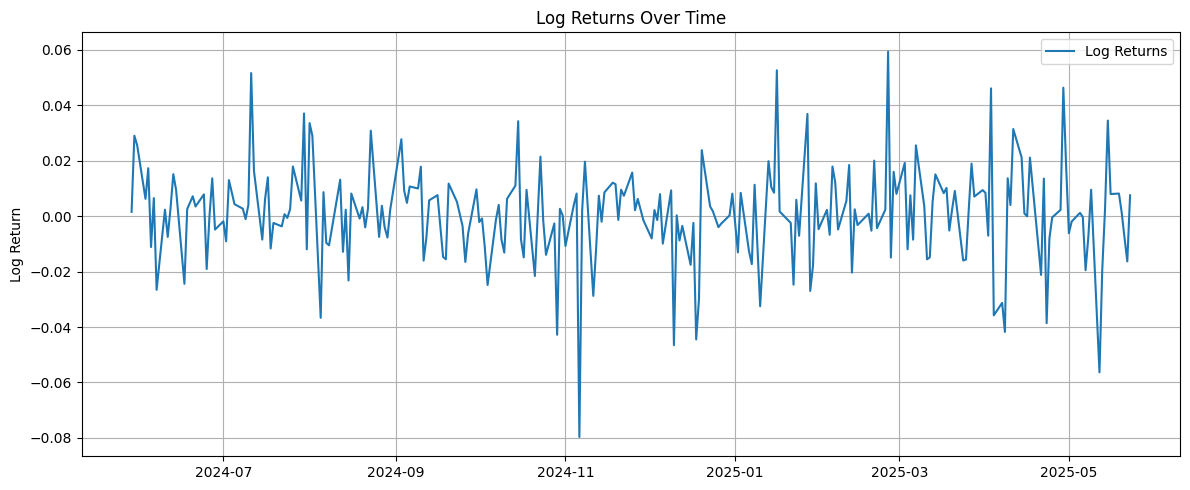

In [13]:
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])


plt.figure(figsize=(12, 5))
plt.plot(return_df['Date'], return_df['Log_Return'], label='Log Returns')

plt.ylabel('Log Return')
plt.title('Log Returns Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Set parameters a b and c for frontier
#set rolling  mean and std

rolling_mean = return_df['Log_Return'].rolling(window=30).mean()
rolling_std = return_df['Log_Return'].rolling(window=30).std()
rolling_mean = rolling_mean.dropna()
rolling_std = rolling_std.dropna()
rolling_mean = rolling_mean.values
rolling_std = rolling_std.values
mu = rolling_mean
S = rolling_std
sigma = 0.04
N = 220
T = 240
nobs = 1000 


Sharpe Ratio: -2.408660864750549


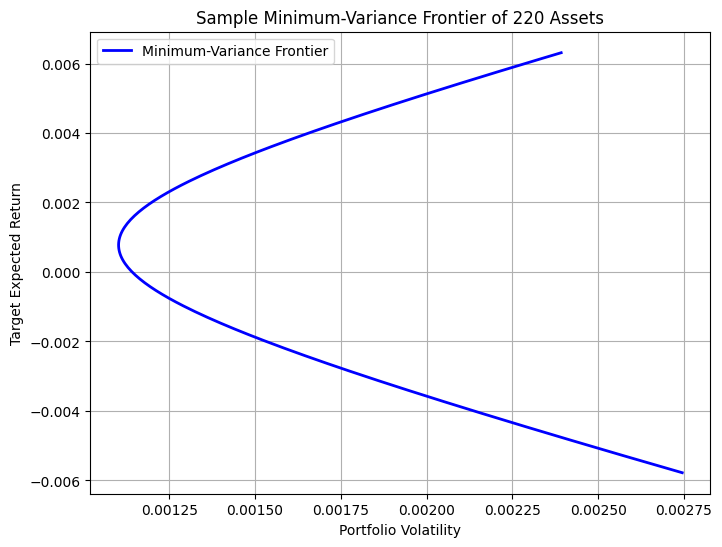

In [24]:
rolling_mean[:5] 
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate)
print(f"Sharpe Ratio: {sharpe_ratio}")
if S.ndim == 1:
    S = np.diag(S**2) 

inv_S = np.linalg.inv(S)
ones = np.ones(N) 

#calculate parameters a,b,c
a_hat = np.dot(mu, inv_S.dot(mu))       
b_hat = np.dot(ones, inv_S.dot(mu))      
c_hat = np.dot(ones, inv_S.dot(ones)) 

def compute_portfolio(mu_p):
    """
    Computing sigma based on given portfolio mean return
    """
    
    # Compute Lagrange multipliers directly inline:
    lambda1 = (a_hat - b_hat * mu_p) / (a_hat * c_hat - b_hat**2)
    lambda2 = (c_hat * mu_p - b_hat) / (a_hat * c_hat - b_hat**2)
    
    # Compute portfolio weights for target return mu_p:
    w = lambda1 * inv_S.dot(ones) + lambda2 * inv_S.dot(mu)
    
    # Compute portfolio volatility:
    sigma_p = np.sqrt(np.dot(w, S.dot(w)))
    return sigma_p

#predefining target return

if len(mu) != len(rolling_mean):
    raise ValueError(f"Length of mu ({len(mu)}) does not match the length of rolling_mean ({len(rolling_mean)}).")

target_returns = np.linspace(min(mu), max(mu), len(mu))

vols = []

for mu_p in target_returns:
    vols.append(compute_portfolio(mu_p))
volatilities = np.array(vols)

plt.figure(figsize=(8, 6))
plt.plot(volatilities, target_returns, 'b-', lw=2)
plt.xlabel("Portfolio Volatility")
plt.ylabel("Target Expected Return")
plt.title("Sample Minimum-Variance Frontier of 220 Assets")
plt.grid(True)
plt.legend(["Minimum-Variance Frontier"])
plt.show()

import json

frontier_data = {
    "volatility": volatilities.tolist(),
    "return": target_returns.tolist()
}

with open("frontier_data.json", "w") as f:
    json.dump(frontier_data, f)



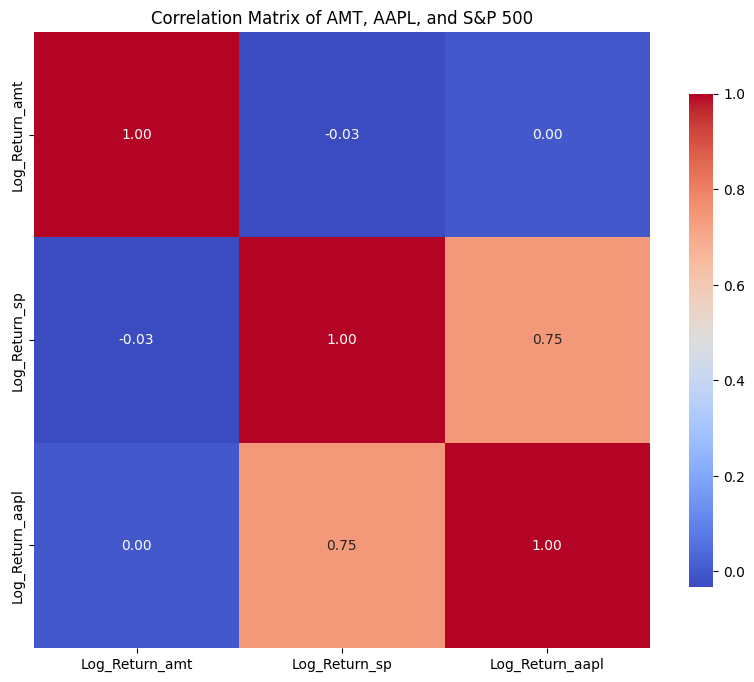

In [23]:
# create a correlation matrix for stocks AMT , AAPL, and S&P 500
altick = ['AAPL']
return_df = yf.download(altick, period="1y", progress=False, threads=False)
return_df_alt= return_df[['Close']].reset_index()
return_df_alt.columns = ['Date', 'Close']
#set log returns for AAPL
return_df_alt['Date'] = pd.to_datetime(return_df_alt['Date'])
return_df_alt['Date'] = return_df_alt['Date'].dt.strftime('%Y-%m-%d')
return_df_alt['Log_Return_aapl'] = np.log(return_df_alt['Close'] / return_df_alt['Close'].shift(1))

altick = ['AMT']
return_df_amt = yf.download(altick, period="1y", progress=False, threads=False)
return_df_amt = return_df_amt[['Close']].reset_index()
return_df_amt.columns = ['Date', 'Close']
# Set log returns for AMT
return_df_amt['Date'] = pd.to_datetime(return_df_amt['Date'])
return_df_amt['Date'] = return_df_amt['Date'].dt.strftime('%Y-%m-%d')
return_df_amt['Log_Return_amt'] = np.log(return_df_amt['Close'] / return_df_amt['Close'].shift(1))

altick = ['^GSPC']  # S&P 500 index
return_df_sp500 = yf.download(altick, period="1y", progress=False, threads=False)
return_df_sp500 = return_df_sp500[['Close']].reset_index()
return_df_sp500.columns = ['Date', 'Close']
# Set log returns for S&P 500
return_df_sp500['Date'] = pd.to_datetime(return_df_sp500['Date'])
return_df_sp500['Date'] = return_df_sp500['Date'].dt.strftime('%Y-%m-%d')
return_df_sp500['Log_Return_sp'] = np.log(return_df_sp500['Close'] / return_df_sp500['Close'].shift(1))



# Create correlation matrix
correlation_matrix = pd.concat([return_df_amt['Log_Return_amt'], return_df_sp500['Log_Return_sp'], return_df_alt['Log_Return_aapl']], axis=1).corr()
plt.figure(figsize=(10, 8))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of AMT, AAPL, and S&P 500")
plt.show()


using capm for SML plot

Expected Return for AMT using CAPM: 0.04466610590982917


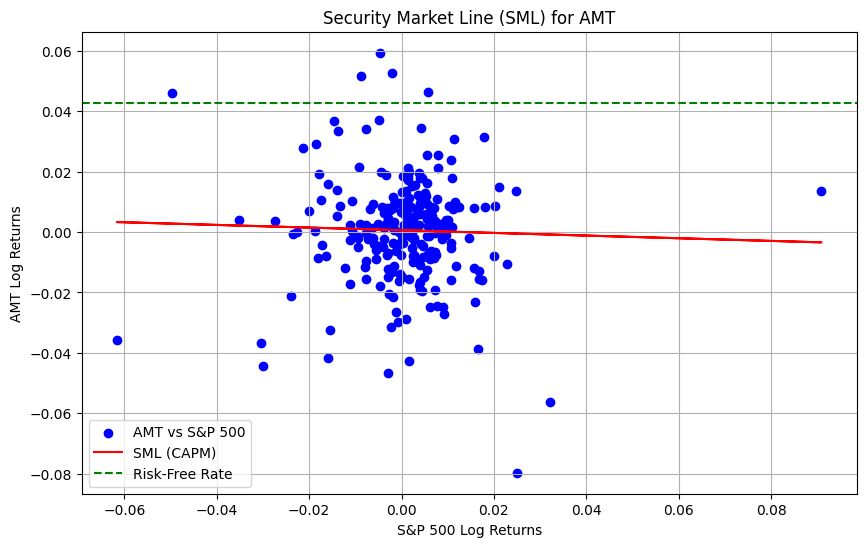

In [ ]:
from sklearn.linear_model import LinearRegression

#plot the SML regression line for AMT vs S&P 500 using CAPM

valid_indices = return_df_sp500['Log_Return_sp'].notna() & return_df_amt['Log_Return_amt'].notna()
return_df_sp500 = return_df_sp500[valid_indices]
return_df_amt = return_df_amt[valid_indices]

X = return_df_sp500['Log_Return_sp'].values.reshape(-1, 1) #reshape value arrays dimenssions
y = return_df_amt['Log_Return_amt'].values.reshape(-1, 1)  # gives beta against the market return

model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
# Calculate the expected return using CAPM
expected_return = risk_free_rate + slope * (return_df_sp500['Log_Return_sp'].mean() - risk_free_rate)
print(f"Expected Return for AMT using CAPM: {expected_return}")
# Plotting the Security Market Line (SML)
plt.figure(figsize=(10, 6))
plt.scatter(return_df_sp500['Log_Return_sp'], return_df_amt['Log_Return_amt'], label='AMT vs S&P 500', color='blue')
plt.plot(return_df_sp500['Log_Return_sp'], model.predict(X), color='red', label='SML (CAPM)')
plt.axhline(y=risk_free_rate, color='green', linestyle='--', label='Risk-Free Rate')
plt.xlabel('S&P 500 Log Returns')
plt.ylabel('AMT Log Returns')
plt.title('Security Market Line (SML) for AMT')
plt.legend()
plt.grid()
plt.show()



